In [23]:
!pip install rdkit

In [1]:
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import Descriptors
from sklearn.preprocessing import FunctionTransformer
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

In [2]:
data_1400 = pd.read_excel('1400.xlsx')
data_1400

,Title,"IC50, mmg/ml","CC50-MDCK, mmg/ml",SI,Molecular weight,Hydrogen bond acceptors,Hydrogen bond donors,Polar SA,SMILES,Pictures
0,1007-Ya-213,2.7,500.0,185.185185,195.307,2,1,32.59,OCC\N=C(\[C@]12C)C[C@@H](C1(C)C)CC2,50.0
1,1007-Ya-213,0.7,447.0,638.571429,195.307,2,1,32.59,OCC\N=C(\[C@]12C)C[C@@H](C1(C)C)CC2,51.0
2,1008-Ya-187,9.9,144.0,14.545455,250.431,1,0,15.60,CCN(CC)CC\N=C(\[C@@]12C)C[C@H](C1(C)C)CC2,52.0
3,1009-As-106,8.3,500.0,60.240964,222.377,1,0,15.60,CN(C)CC\N=C(\[C@@]12C)C[C@H](C1(C)C)CC2,53.0
4,1010-Ya-208,39.4,143.0,3.629442,239.361,2,0,29.54,CN(C)CC(=O)O[C@H]1C[C@H](CC2)C(C)(C)[C@@]12C,54.0
...,...,...,...,...,...,...,...,...,...,...
1463,CHEMBL4251117,7.3,530.6,72.800000,238.330,3,0,39.44,CCCCCCCc1c(OC)c(C)c(=O)oc1,NaN
1464,CHEMBL4217515,3.8,4733.9,1250.000000,427.417,2,1,124.74,COc(cc1)cc(c12)ccc(c2)-c(c3C([O-])=O)c(C([O-])...,NaN
1465,CHEMBL4205814,0.3,4733.9,14285.700000,427.417,2,1,124.74,COc(cc1)cc(c12)ccc(c2)-c(c3C([O-])=O)c(C([O-])...,NaN
1466,CHEMBL4212064,0.7,3662.8,5555.600000,320.304,1,0,89.49,c1ccc(C([O-])=O)c(c1C([O-])=O)-c(c2)ccc(c23)cc...,NaN


In [3]:
data_1400.describe()

,"IC50, mmg/ml","CC50-MDCK, mmg/ml",SI,Molecular weight,Hydrogen bond acceptors,Hydrogen bond donors,Polar SA,Pictures
count,1468.000000,1468.000000,1.444000e+03,1468.000000,1468.000000,1468.000000,1468.000000,727.000000
mean,50.277063,186.491530,2.217641e+04,384.739636,3.831744,1.333787,81.273215,364.909216
std,92.184768,1009.454293,4.726006e+05,153.164268,2.860473,1.803663,54.078778,210.154325
min,0.000010,0.031928,0.000000e+00,110.157000,0.000000,0.000000,0.000000,1.000000
25%,2.500000,30.375000,1.885549e+00,283.049250,2.000000,0.000000,39.440000,183.500000
50%,10.100000,90.400000,5.600000e+00,349.371000,3.000000,1.000000,71.840000,365.000000
75%,49.450000,300.000000,2.832642e+01,446.508000,5.000000,2.000000,106.160000,546.500000
max,1000.000000,37646.000000,1.596170e+07,1159.380000,19.000000,11.000000,319.510000,728.000000


### Проверим пропуски в данных

In [4]:
data_1400[["IC50, mmg/ml", "CC50-MDCK, mmg/ml", "SI", "SMILES"]].count()

IC50, mmg/ml         1468
CC50-MDCK, mmg/ml    1468
SI                   1444
SMILES               1468
dtype: int64

### Заполним пропуски индекса SI на основе CC50 и IC50

In [5]:
nan_msk = data_1400["SI"].isna()
data_1400.loc[nan_msk, "SI"] = data_1400["CC50-MDCK, mmg/ml"][nan_msk] / data_1400["IC50, mmg/ml"][nan_msk]

### Рассчитаем дескрипторы из библиотеки rdkit

In [6]:
def calc_descriptors(mols):
    return pd.DataFrame((Descriptors.CalcMolDescriptors(Chem.MolFromSmiles(m)) for m in mols))

descriptors_transformer = FunctionTransformer(calc_descriptors)
X = descriptors_transformer.transform(data_1400['SMILES'])
X = X.drop(X.columns[(X.describe().loc["count"] < len(X))], axis=1)

[10:32:49] Conflicting single bond directions around double bond at index 55.
[10:32:49]   BondStereo set to STEREONONE and single bond directions set to NONE.


In [7]:
X.columns

Index(['MaxAbsEStateIndex', 'MaxEStateIndex', 'MinAbsEStateIndex',
       'MinEStateIndex', 'qed', 'MolWt', 'HeavyAtomMolWt', 'ExactMolWt',
       'NumValenceElectrons', 'NumRadicalElectrons',
       ...
       'fr_sulfide', 'fr_sulfonamd', 'fr_sulfone', 'fr_term_acetylene',
       'fr_tetrazole', 'fr_thiazole', 'fr_thiocyan', 'fr_thiophene',
       'fr_unbrch_alkane', 'fr_urea'],
      dtype='object', length=197)

### Посмотрим, есть ли линейные зависимости между индексом SI и найденными дескрипторами

<Axes: >

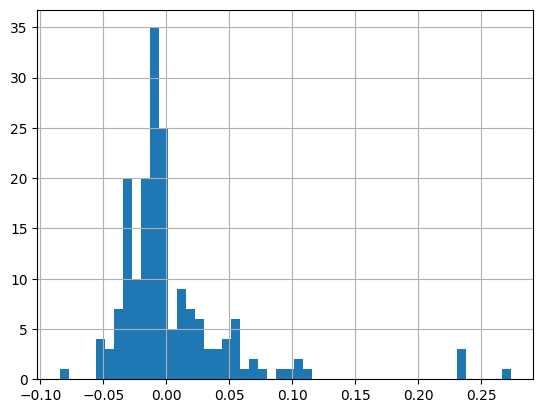

In [8]:
corrs = X.corrwith(data_1400["SI"], numeric_only=True)
corrs.hist(bins=50)

In [9]:
corrs[corrs > .2].sort_values(ascending=False)

fr_tetrazole    0.273673
fr_Ar_NH        0.234275
fr_Nhpyrrole    0.234275
fr_Ar_COO       0.233313
dtype: float64

### Таким образом, линейная корреляция между искомым индексом SI и дескрипторами небольшая, максимальное значение корреляции Пирсона: 0.27 для признака _fr_tetrazole_

### Посмотрим статистику по индексу SI и концентрациям IC50 и CC50-MDCK

In [10]:
data_1400[["IC50, mmg/ml", "CC50-MDCK, mmg/ml", "SI", "SMILES"]].describe()

,"IC50, mmg/ml","CC50-MDCK, mmg/ml",SI
count,1468.000000,1468.000000,1.468000e+03
mean,50.277063,186.491530,2.181397e+04
std,92.184768,1009.454293,4.687273e+05
min,0.000010,0.031928,0.000000e+00
25%,2.500000,30.375000,1.833333e+00
50%,10.100000,90.400000,5.500000e+00
75%,49.450000,300.000000,2.805929e+01
max,1000.000000,37646.000000,1.596170e+07


### Виден большой разброс, особенно в значениях индекса SI, у которого среднее зачение на несколько порядков больше медианного, что говорит о смещении распределения влево. Изобразим распределение для одной из величин:

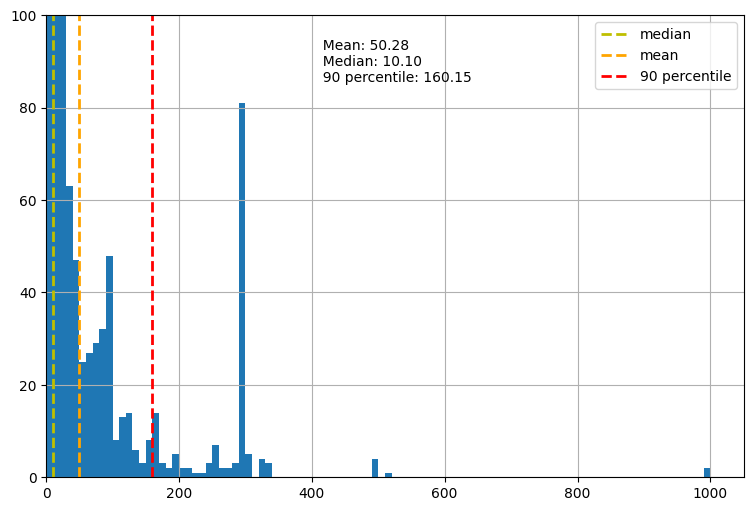

In [11]:
plt.figure(figsize=(9,6))
data_1400["IC50, mmg/ml"].hist(bins=100)

plt.axvline(data_1400['IC50, mmg/ml'].median(), color='y', linestyle='dashed', linewidth=2, label="median")
plt.axvline(data_1400['IC50, mmg/ml'].mean(), color='orange', linestyle='dashed', linewidth=2, label="mean")
plt.axvline(data_1400['IC50, mmg/ml'].quantile(q=0.9), color='r', linestyle='dashed', linewidth=2, label="90 percentile")

plt.text(350, 82,
         '''
          Mean: {:.2f}
          Median: {:.2f}
          90 percentile: {:.2f}
        '''.format(data_1400['IC50, mmg/ml'].mean(), data_1400['IC50, mmg/ml'].median(), data_1400['IC50, mmg/ml'].quantile(q=0.9)))

plt.legend()
plt.xlim(0, )
plt.ylim(0, 100);

### Помимо сильного смещения, заметно большое число точек со значением концентрации 300 мкг/мл, связанное со спецификой проведения опытов. Поэтому попробуем обрезать данные по этому значению:

In [12]:
data_1400_c = data_1400[["IC50, mmg/ml", "CC50-MDCK, mmg/ml", "SI", "SMILES"]][data_1400['IC50, mmg/ml'] < 300]
X_c = X[data_1400['IC50, mmg/ml'] < 300]

### Попробуем применить случайный лес и оценить важность признаков

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X_c, data_1400_c["IC50, mmg/ml"], random_state=42)

forest = RandomForestRegressor(random_state=0)
forest.fit(X_train, y_train)

RandomForestRegressor(random_state=0)

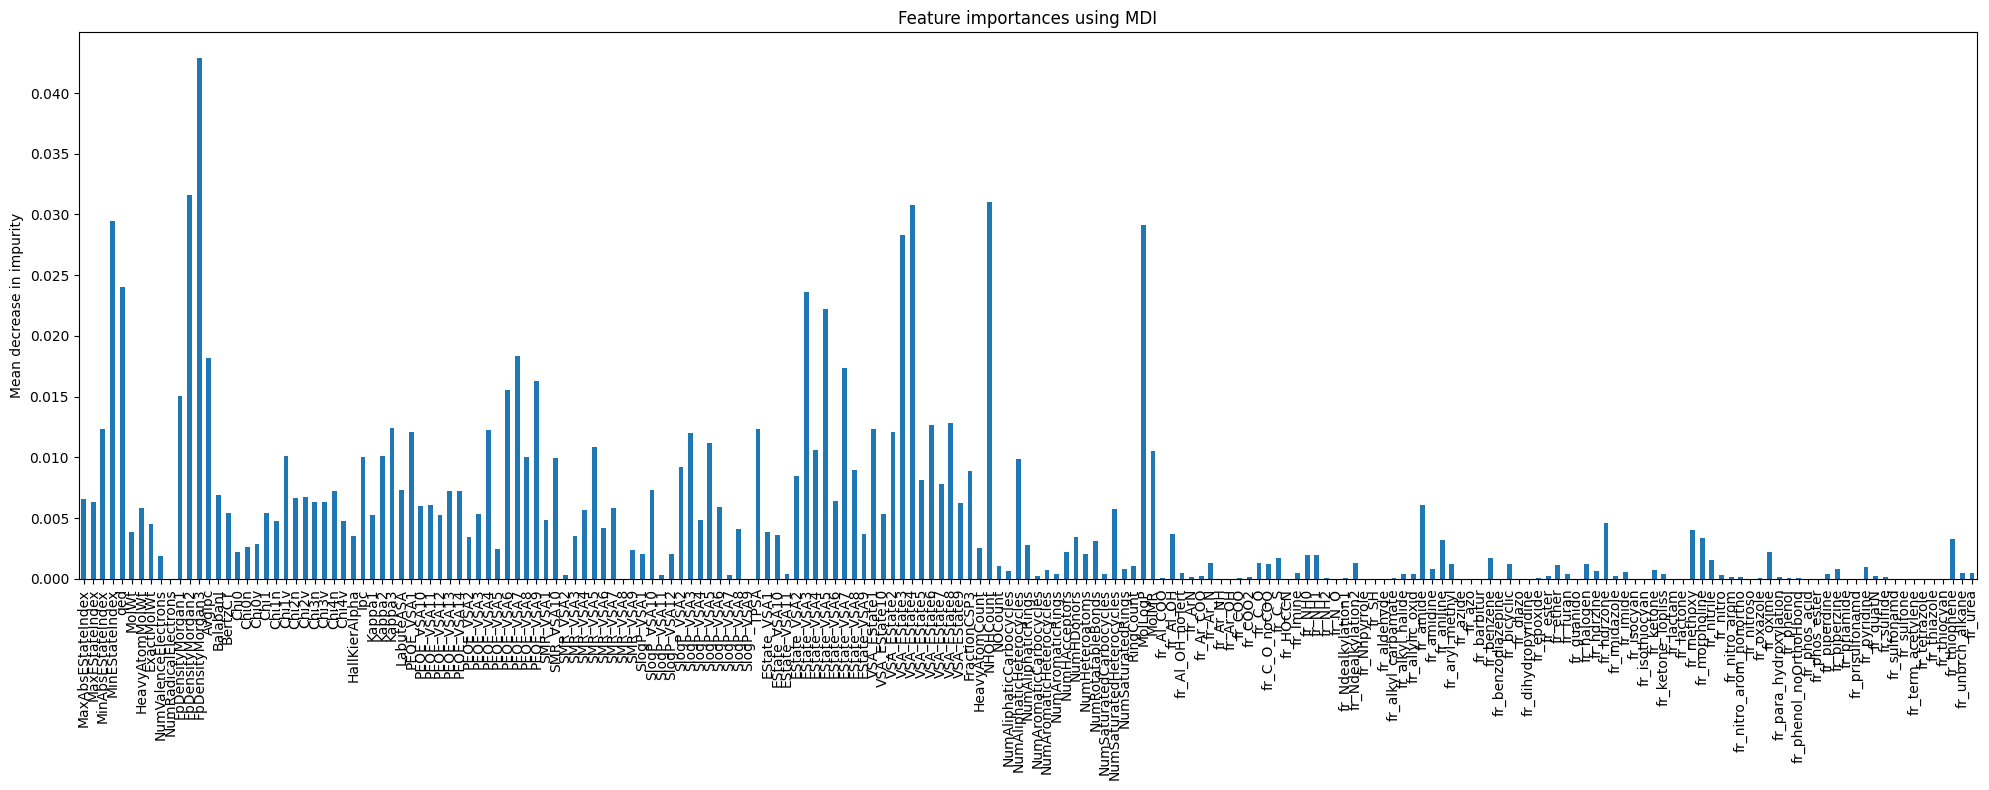

In [14]:
forest_importances = pd.Series(forest.feature_importances_, index=X.columns)

fig, ax = plt.subplots(figsize=(20,8))
forest_importances.plot.bar(ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

In [15]:
forest_importances.sort_values(ascending=False)

FpDensityMorgan3    0.042852
FpDensityMorgan2    0.031577
NHOHCount           0.031003
VSA_EState4         0.030744
MinEStateIndex      0.029481
                      ...   
fr_lactam           0.000000
fr_N_O              0.000000
fr_isothiocyan      0.000000
fr_isocyan          0.000000
fr_barbitur         0.000000
Length: 197, dtype: float64

### Можно сделать вывод, что для леса наибольший вклад в минимизацию ошибки вносит признак _FpDensityMorgan3_, однако значения _feature_importance_ невелико

### Рассмотрим датасет из 35000 семплов

In [16]:
data_35000 = pd.read_excel('35000.xlsx')
data_35000.head()

,Unnamed: 0,Title,IC50,SMILES
0,NaN,CHEMBL2206459,0.000015,[H]\N=C(N)\N[C@@H](C1)[C@@H](NC(=O)C)[C@@H](C=...
1,NaN,CHEMBL3818159,0.000016,O=C(O)C1=C[C@H](N)[C@@H](NC(=O)C)[C@@H](C1)COC...
2,NaN,CHEMBL1956716,0.000033,C=CC(=O)N[C@H]([C@H](C1)N)[C@@H](C=C1C([O-])=O...
3,NaN,CHEMBL1956715,0.000032,CC(=O)N[C@H]([C@H](C1)N)[C@@H](C=C1C([O-])=O)O...
4,NaN,CHEMBL4444029,0.000041,O=C(O)c1c(O)c(=O)cc([nH]1)-c(c2C)ccc(c2)-c3noc...


In [17]:
data_35000 = data_35000.drop(data_35000.columns[0], axis=1)
data_35000.head()

,Title,IC50,SMILES
0,CHEMBL2206459,0.000015,[H]\N=C(N)\N[C@@H](C1)[C@@H](NC(=O)C)[C@@H](C=...
1,CHEMBL3818159,0.000016,O=C(O)C1=C[C@H](N)[C@@H](NC(=O)C)[C@@H](C1)COC...
2,CHEMBL1956716,0.000033,C=CC(=O)N[C@H]([C@H](C1)N)[C@@H](C=C1C([O-])=O...
3,CHEMBL1956715,0.000032,CC(=O)N[C@H]([C@H](C1)N)[C@@H](C=C1C([O-])=O)O...
4,CHEMBL4444029,0.000041,O=C(O)c1c(O)c(=O)cc([nH]1)-c(c2C)ccc(c2)-c3noc...


### Проверка пропусков

In [18]:
data_35000[data_35000.isna().any(axis=1)]

,Title,IC50,SMILES


### Расчет статистики

In [19]:
data_35000.describe()

,IC50
count,36377.000000
mean,7.813503
std,48.489710
min,0.000010
25%,1.696000
50%,3.635000
75%,5.934000
max,3183.600000


### Построим график распределения значений

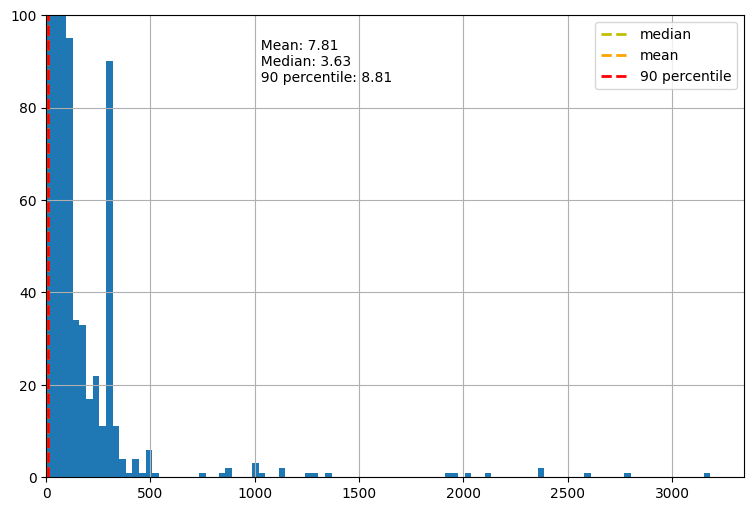

In [20]:
plt.figure(figsize=(9,6))
data_35000["IC50"].hist(bins=100)

plt.axvline(data_35000['IC50'].median(), color='y', linestyle='dashed', linewidth=2, label="median")
plt.axvline(data_35000['IC50'].mean(), color='orange', linestyle='dashed', linewidth=2, label="mean")
plt.axvline(data_35000['IC50'].quantile(q=0.9), color='r', linestyle='dashed', linewidth=2, label="90 percentile")

plt.text(820, 82,
         '''
          Mean: {:.2f}
          Median: {:.2f}
          90 percentile: {:.2f}
        '''.format(data_35000['IC50'].mean(), data_35000['IC50'].median(), data_35000['IC50'].quantile(q=0.9)))


plt.legend()
plt.xlim(0, )
plt.ylim(0, 100);

### На большей выборке также заметно сильное смещение распределения, более 90% семплов попадают в интервал до 9 мкг/мл, но при этом отдельные выбросы доходят до значений более 3000 мкг/мл. Так же, как и в датасете на 1400 семплов многие значения ограничиваются порогом 300 мкг/мл, поэтому при посторении моделей имеет смысл обрезать датасет по такому значению

In [23]:
data_35000[data_35000['IC50'] < 300].describe()

,IC50
count,36239.000000
mean,5.844286
std,14.404000
min,0.000010
25%,1.686000
50%,3.626000
75%,5.892000
max,299.700000
